# Analysing 1D SWE model outputs across a variety of different parameters

Recall the SWE:

\begin{align*}
    \partial_t u + u \cdot \nabla u + g \nabla \eta - \nu \nabla^2 u &= 0, \\
    \partial_t \eta + \nabla \cdot ((\eta + \eta) u) &= 0.
\end{align*}

For our paper simulation study -- and thus, also in this notebook -- we are looking at analysing the results of running statFEM for the SWE, with different viscosity parameters $\nu$, topographies $H$, and observation intervals. We will mainly analyse outputs in terms of the relative RMSE:

\begin{equation*}
    \mathrm{RMSE} = \frac{\Vert y_m - H(u_m, h_m)\Vert}{\Vert y_m \Vert},
\end{equation*}

and also the (negative) log-likelihoods for a probabilistic metric for comparison.

In [36]:
import h5py

import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import xarray as xr

import sys
sys.path.insert(0, "../scripts")
from figures import figure_sizes

def errors_from_output_file(output_file, prior=False):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    c = checkpoint["/"].attrs["c"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    assert checkpoint["/"].attrs["rho_h"] == 1e-2 
    t_obs = checkpoint["/t_obs"][:]
    rmse = checkpoint["/rmse"][:]
    rmse_rel = checkpoint["/rmse_rel"][:]
    
    # common coordinates across all
    coords=dict(t=t_obs,
                nu=np.array([nu]),
                c=np.array([c]),
                nt_skip=np.array([nt_skip]))
    
    rmse_ds = xr.DataArray(data=rmse[:, np.newaxis, np.newaxis, np.newaxis],
                           coords=coords,
                           name="rmse")
    rmse_rel_ds = xr.DataArray(data=rmse_rel[:, np.newaxis, np.newaxis, np.newaxis],
                               coords=coords,
                               name="rmse_rel")
    if not prior:
        lml = checkpoint["/lml"][:]
        checkpoint.close()
        
        lml_ds = xr.DataArray(data=lml[:, np.newaxis, np.newaxis, np.newaxis],
                              coords=coords,
                              name="lml")
        return (nu, nt_skip), xr.merge([rmse_ds, rmse_rel_ds, lml_ds])
    else:
        checkpoint.close()
        return (nu, nt_skip), xr.merge([rmse_ds, rmse_rel_ds])

In [2]:
from glob import glob

output_files = glob(
    "../outputs/swe-bump/*-posterior-c-*-nt_skip-*.h5")

errors_ds = []
for output_file in output_files:
    _, e = errors_from_output_file(output_file)
    errors_ds.append(e)

errors_nonlinear = xr.merge(errors_ds)
errors_nonlinear

<xarray.Dataset>
Dimensions:   (t: 20000, nu: 7, c: 8, nt_skip: 6)
Coordinates:
  * t         (t) float64 0.01 0.02 0.03 0.04 0.05 ... 200.0 200.0 200.0 200.0
  * nu        (nu) float64 0.0 1e-06 0.0001 0.01 1.0 100.0 1e+04
  * c         (c) float64 5.0 7.0 10.0 11.0 12.0 15.0 20.0 22.0
  * nt_skip   (nt_skip) int64 1 5 10 25 100 500
Data variables:
    rmse      (t, nu, c, nt_skip) float64 6.055e-05 6.055e-05 ... nan nan
    rmse_rel  (t, nu, c, nt_skip) float64 0.1217 0.1217 0.1217 ... nan nan nan
    lml       (t, nu, c, nt_skip) float64 -1.163e+08 -1.163e+08 ... nan nan

In [3]:
output_files_prior = glob(
    "../outputs/swe-bump/*-prior-c-*-nt_skip-50-*.h5")

errors_ds = []
for output_file in output_files_prior:
    _, e = errors_from_output_file(output_file, prior=True)
    errors_ds.append(e)

errors_prior = xr.merge(errors_ds)
errors_prior

<xarray.Dataset>
Dimensions:   (t: 400, nu: 7, c: 8, nt_skip: 1)
Coordinates:
  * t         (t) float64 0.01 0.51 1.01 1.51 2.01 ... 198.0 198.5 199.0 199.5
  * nu        (nu) float64 0.0 1e-06 0.0001 0.01 1.0 100.0 1e+04
  * c         (c) float64 5.0 7.0 10.0 11.0 12.0 15.0 20.0 22.0
  * nt_skip   (nt_skip) int64 50
Data variables:
    rmse      (t, nu, c, nt_skip) float64 6.055e-05 6.055e-05 ... 0.0004572
    rmse_rel  (t, nu, c, nt_skip) float64 0.1217 0.1217 0.1217 ... 2.836 2.836

Now we filter the output information to that which we are actually interested.

In [4]:
errors_prior = errors_prior.isel(c=[0, 2, 5, 6])
errors_nonlinear = errors_nonlinear.isel(c=[0, 1, 2, 5, 6])

## Checking performance across observation times

First we plot the results across the different observation intervals to see how things stack up across time. We first look at the relative errors across time, for different values of `nt_skip`, for the true value of $c$:

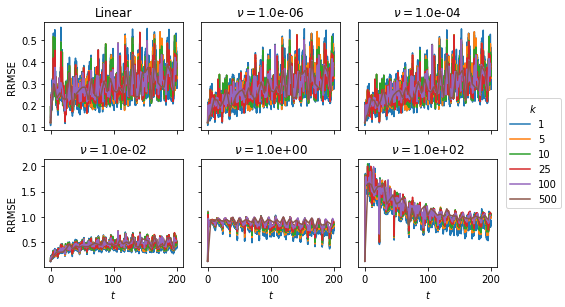

In [43]:
assert errors_nonlinear.coords["c"][2] == 10.

nus =  errors_nonlinear.coords["nu"].to_numpy()
labels = [
    fr"$\nu = ${nu:.1e}" if nu > 0 else "Linear" for nu in nus
]

p = errors_nonlinear.rmse_rel.isel(c=2, nu=slice(0, 6)).interpolate_na(dim="t").plot(
    hue="nt_skip", col="nu", col_wrap=3,
    figsize=(figure_sizes["fullwidth"], 0.6 * figure_sizes["fullwidth"]),
    sharex=True, sharey="row")

# figure customization
p.figlegend.set_title(r"$k$")
for i, ax in enumerate(p.axes.flat):
    ax.set_title(labels[i])

for ax in p.axes[1, :]:
    ax.set_xlabel(r"$t$")

for ax in p.axes[:, 0]:
    ax.set_ylabel("RRMSE") 
    
plt.savefig("../figures/swe-bump-paper/nt-skip-nu-grid.pdf", dpi=600)

And, again, for the relative errors for different $c$ values for the linear model:

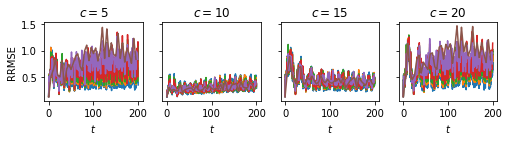

In [115]:
p = errors_nonlinear.rmse_rel.isel(nu=0, c=[0, 2, 3, 4]).interpolate_na(dim="t").plot(
    hue="nt_skip", col="c", col_wrap=4,
    figsize=(figure_sizes["fullwidth"], 0.28 * figure_sizes["fullwidth"]),
    sharey=True)

# figure customization
# p.figlegend.set_title(r"$k$")
p.figlegend.remove()

cs =  errors_nonlinear.coords["c"].to_numpy()[[0, 2, 3, 4]]
labels = [fr"$c = {c:.0f}$" for c in cs]
for i, ax in enumerate(p.axes.flat):
    ax.set_title(labels[i])

for ax in p.axes.flat:
    ax.set_xlabel(r"$t$")

p.axes[0, 0].set_ylabel("RRMSE") 
plt.savefig("../figures/swe-bump-paper/nt-skip-c-grid.pdf", dpi=600)

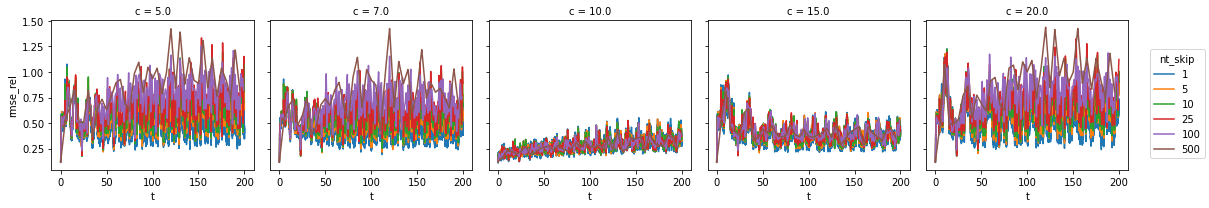

In [7]:
errors_nonlinear.rmse_rel.isel(nu=1).interpolate_na(dim="t").plot(
    hue="nt_skip", col="c", sharey=True)
plt.show()

The results are decent across the the board with minor stratifications between the models across for different `nt_skip` values, but with greater stratification from changing parameter values. This leads to the conclusion that the different time-differences between observations does not drive the variation in model performance, in this scenario.

In [108]:
ave_rmse = errors_nonlinear.isel(c=2).mean(dim="t", skipna=True).rmse_rel
dat = ave_rmse.to_numpy().T

def format_col(col):
    min_loc = col.argmin()
    out = col.astype(str)
    
    for i in range(len(col)):
        if i == min_loc:
            out[i] = fr"$\mathbf{{{col[i]:.6f}}}$"
        else:
            out[i] = fr"${col[i]:.6f}$"

    return np.array(out)
            
dat_formatted = np.apply_along_axis(format_col, 0, dat)

with open("../figures/swe-bump-paper/nt-skip-nu-table.tex", "w") as f:
    f.write(tabulate(dat_formatted,
                     ave_rmse.coords["nu"].to_numpy(),
                     showindex=ave_rmse["nt_skip"].to_numpy(),
                     tablefmt="latex_raw"))

/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


In [109]:
ave_rmse = errors_nonlinear.isel(nu=0).mean(dim="t", skipna=True).rmse_rel

dat = ave_rmse.to_numpy().T
dat_formatted = np.apply_along_axis(format_col, 0, dat)

with open("../figures/swe-bump-paper/nt-skip-c-table.tex", "w") as f:
    f.write(tabulate(dat_formatted, 
                     ave_rmse.coords["c"].to_numpy(),
                     showindex=ave_rmse["nt_skip"].to_numpy(),
                     tablefmt="latex_raw"))

/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


## Checking performance for misspecified model parameters, with fixed observation times

First, we plot the results across the different values of the $c$ parameter (centre of the bump), when $\nu$ is set to sensible values. To get a feel for how conditioning on data helps, we first plot the prior:

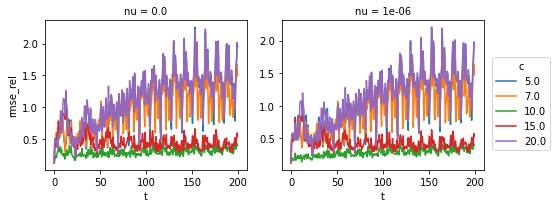

In [10]:
errors_prior.rmse_rel.interpolate_na(dim="t").isel(nu=[0, 1]).plot(
    hue="c", col="nu", sharey=False)
plt.show()

Next, we plot the posterior. On the left, below, are the results for the linear model, and on the right are the results of the nonlinear model. Results are sensible with quite significant stratification across the $c$ values. We see that there is a reasonable drop in the relative errors in comparison to the prior:

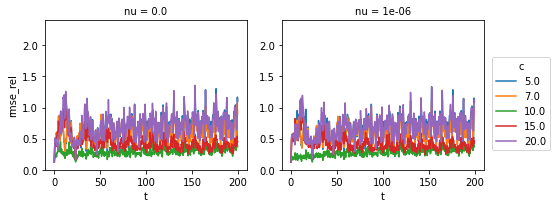

In [11]:
errors_nonlinear.rmse_rel.interpolate_na(dim="t").isel(nt_skip=3, nu=[0, 1]).plot(
    hue="c", col="nu", sharey=False, ylim=[0., 2.4])
plt.show()

Next, we plot these same results, but we instead use the log-marginal likelihood as the metric. The stratification here becomes more apparent across the board:

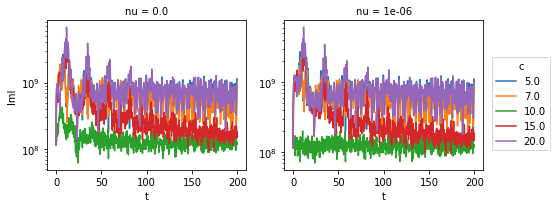

In [12]:
np.abs(errors_nonlinear).lml.interpolate_na(dim="t").isel(nt_skip=3, nu=[0, 1]).plot(
    hue="c", col="nu", sharey=False, yscale="log")
plt.show()

And now for total comparison we show all of these results, for all the $\nu$ values:

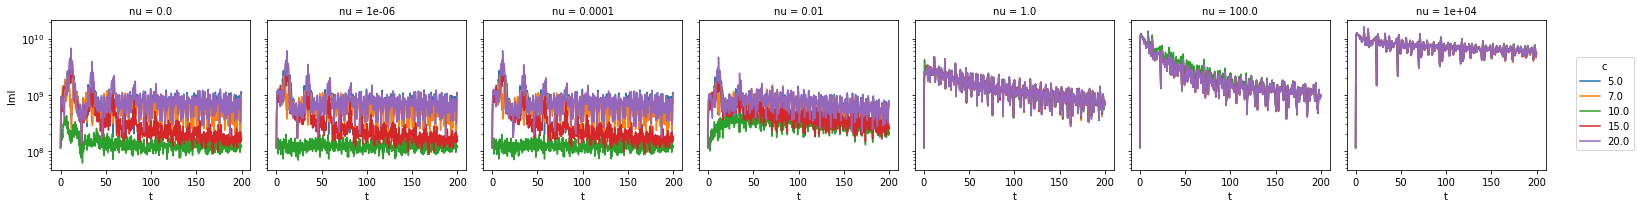

In [13]:
np.abs(errors_nonlinear.lml).isel(nt_skip=3).interpolate_na(dim="t").plot(
    hue="c", col="nu", sharey=True, yscale="log")
plt.show()

Next, we plot the results for the true value of $c$, for the various values of $\nu$. We see that there is a drastic change in the dynamics as we increase $\nu \geq 1$; once setting $\nu = 1$ this induces a degree of mismatch which results in the model not improving *a posteriori*:

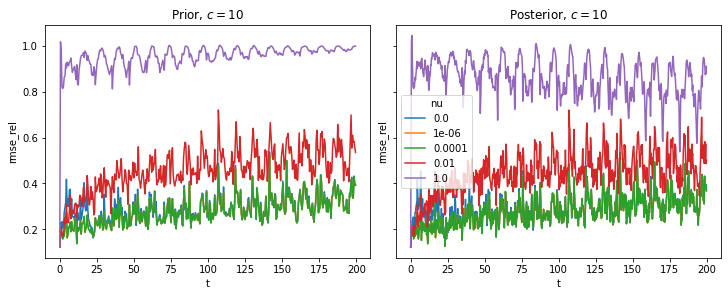

In [14]:
nu = [0, 1, 2, 3, 4]
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4), sharey=True)
errors_prior.rmse_rel.isel(nu=nu, c=2).interpolate_na(dim="t").plot(
    hue="nu", ax=ax[0], add_legend=False)
ax[0].set_title("Prior, $c = 10$")
errors_nonlinear.rmse_rel.isel(nt_skip=3, nu=nu, c=2).interpolate_na(dim="t").plot(
    hue="nu", ax=ax[1], add_legend=True)
ax[1].set_title("Posterior, $c = 10$")
plt.show()

Next, we plot the log-marginal likelihoods for the true value $c = 10$, again stratified across the different $\nu$ values. In this case we see that there is a clear stratification as a result of the $\nu$.

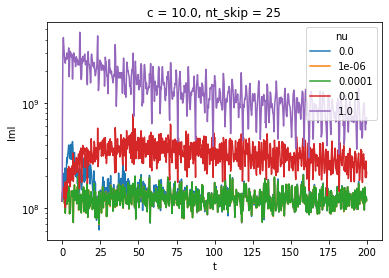

In [15]:
nu = nu
np.abs(errors_nonlinear.lml).isel(nt_skip=3, nu=nu, c=2).interpolate_na(dim="t").plot(
    hue="nu", add_legend=True, yscale="log")
plt.show()

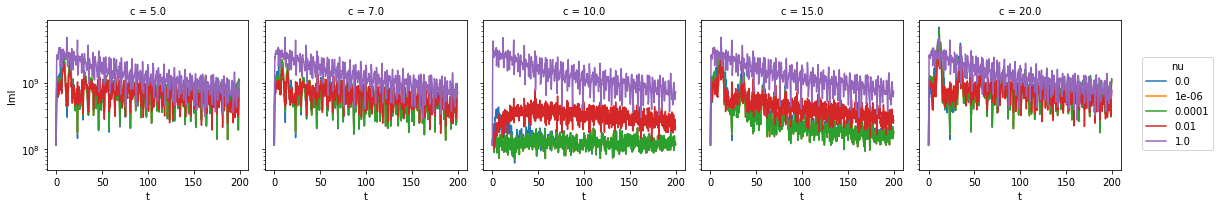

In [16]:
np.abs(errors_nonlinear.lml).isel(nt_skip=3, nu=nu).interpolate_na(dim="t").plot(
    hue="nu", col="c", sharey=True, yscale="log")
plt.show()

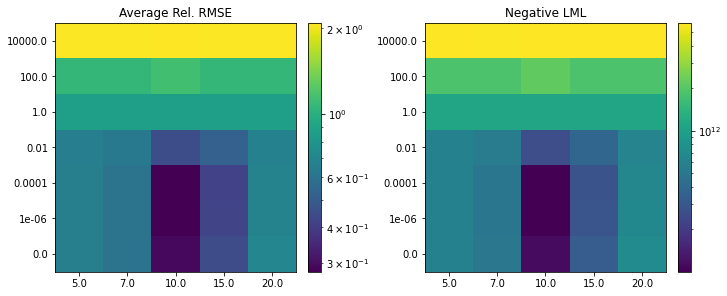

In [17]:
import matplotlib.colors as colors

# mean the RMSEs, sum the LMLs
total_rmse = errors_nonlinear.isel(nt_skip=3).mean(dim="t").rmse_rel
total_lml = np.abs(errors_nonlinear.isel(nt_skip=3).lml).sum(dim="t")

rmse_array = total_rmse.to_numpy()[:, :]
lml_array = total_lml.to_numpy()[:, :]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
im = ax[0].pcolormesh(range(len(total_rmse.coords["c"].to_numpy())), 
                      range(len(total_rmse.coords["nu"].to_numpy())),
                      rmse_array,
                      norm=colors.LogNorm(vmin=rmse_array.min(), 
                                          vmax=rmse_array.max()))
ax[0].set_xticks(range(len(total_rmse.coords["c"].to_numpy())), 
                 total_rmse.coords["c"].to_numpy())
ax[0].set_yticks(range(len(total_rmse.coords["nu"].to_numpy())), 
                 total_rmse.coords["nu"].to_numpy())
ax[0].set_title("Average Rel. RMSE")
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(range(len(total_lml.coords["c"].to_numpy())), 
                      range(len(total_lml.coords["nu"].to_numpy())),
                      lml_array,
                      norm=colors.LogNorm(vmin=lml_array.min(), 
                                          vmax=lml_array.max()))
ax[1].set_xticks(range(len(total_lml.coords["c"].to_numpy())), 
                 total_lml.coords["c"].to_numpy())
ax[1].set_yticks(range(len(total_lml.coords["nu"].to_numpy())), 
                 total_lml.coords["nu"].to_numpy())
ax[1].set_title("Negative LML")
plt.colorbar(im, ax=ax[1])
plt.show()

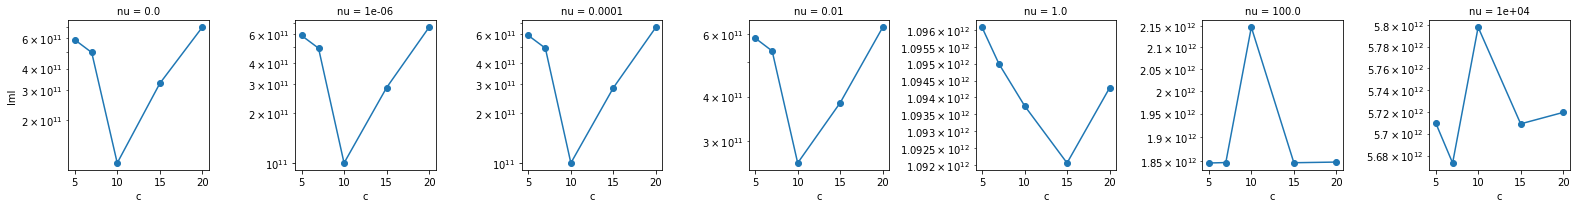

In [18]:
total_lml.plot(marker="o", col="nu", yscale="log", sharey=False)
plt.show()

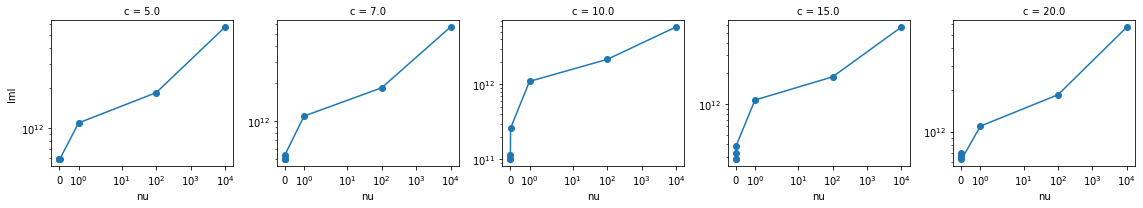

In [19]:
total_lml.plot(marker="o", col="c", xscale="symlog", yscale="log",sharey=False)
plt.show()

In [20]:
print(tabulate(total_lml, 
               headers=total_lml.coords['c'].to_numpy(),
               showindex=total_lml.coords['nu'].to_numpy()))

                    5.0          7.0         10.0         15.0         20.0
----------  -----------  -----------  -----------  -----------  -----------
    0       5.90111e+11  4.9736e+11   1.1316e+11   3.28377e+11  6.98056e+11
    1e-06   5.89425e+11  4.94043e+11  1.00139e+11  2.85538e+11  6.61561e+11
    0.0001  5.87131e+11  4.92334e+11  1.00176e+11  2.8463e+11   6.58652e+11
    0.01    5.85422e+11  5.3828e+11   2.60255e+11  3.84878e+11  6.28167e+11
    1       1.09609e+12  1.095e+12    1.09376e+12  1.09206e+12  1.09428e+12
  100       1.84552e+12  1.84645e+12  2.14764e+12  1.8461e+12   1.84745e+12
10000       5.7101e+12   5.67338e+12  5.79806e+12  5.70906e+12  5.71953e+12


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:
